In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import seaborn as sns
sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import matplotlib as mpl
import glob
import h5py



In [2]:
root = "/home1/08942/nianyic/scratch3/Astrid/subfind/subfind-225"

In [30]:
chunk = 232
tabfile = glob.glob(root + "/chunk%d.*/output/fof_subhalo_tab_225.hdf5"%chunk)[0]
subfile = glob.glob(root + "/chunk%d.*/output/snap_225.hdf5"%chunk)[0]

print(tabfile)

tab = h5py.File(tabfile, "r")
sub = h5py.File(subfile, "r")

tab.keys()



/home1/08942/nianyic/scratch3/Astrid/subfind/subfind-225/chunk232.4083/output/fof_subhalo_tab_225.hdf5


<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

Groupidx: 16 Subgroup idx: 2073
144115371176583329


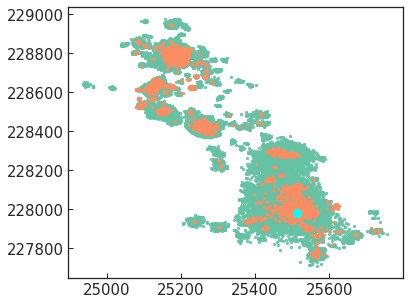

Groupidx: 16 Subgroup idx: 2074
72057776645181033
4


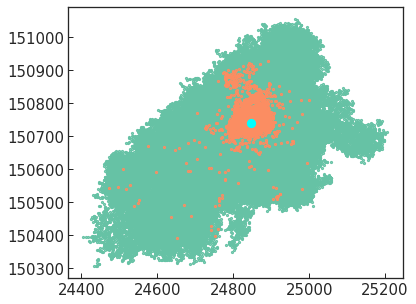

Groupidx: 17 Subgroup idx: 2075
72057776312546522


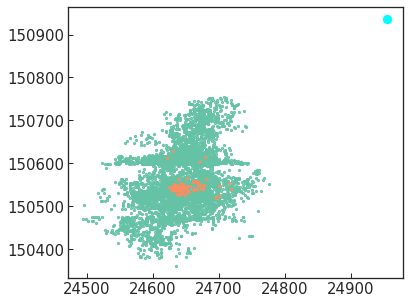

Groupidx: 17 Subgroup idx: 2076
16262371107


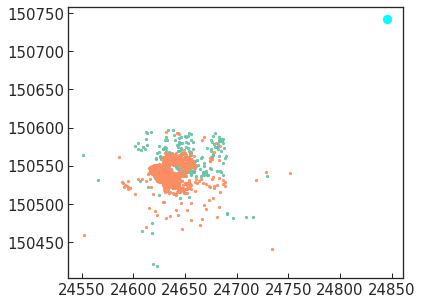

In [39]:
# select = np.random.choice(toublelist, 5)
select = [2073, 2074, 2075, 2076]

for sidx in select:
    # sidx = 4893
    gidx = (gFirst >= sidx).nonzero()[0][0]
    print("Groupidx:", gidx, "Subgroup idx:", sidx)
    cid = cenID[sidx]
    print(cid)
    sbeg, send = sOff[sidx], sOff[sidx] + sLen[sidx]


    # id0 = sub["PartType0"]["ParticleIDs"][sbeg[0] : send[0]]
    # id1 = sub["PartType1"]["ParticleIDs"][sbeg[1] : send[1]]
    # id4 = sub["PartType4"]["ParticleIDs"][sbeg[4] : send[4]]
    # id5 = sub["PartType5"]["ParticleIDs"][sbeg[5] : send[5]]

    for ip in [0,1,4,5]:
        ids = sub["PartType%d"%ip]["ParticleIDs"][sbeg[ip] : send[ip]]
        if cid in ids:
            print(ip)
            
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    pos1 = sub["PartType1"]["Coordinates"][sbeg[1] : send[1]]
    pos4 = sub["PartType4"]["Coordinates"][sbeg[4] : send[4]]
    posc = sPos[sidx]
    ax.scatter(pos1[:, 0], pos1[:, 1], s=1)
    ax.scatter(pos4[:, 0], pos4[:, 1], s=1)
    ax.scatter(posc[0], posc[1], s=50, c="cyan")
    plt.show()



In [4]:
def subhalo_offset(tabfile):
    SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
    GroupLenType = h5py.File(tabfile,'r')['Group']['GroupLenType'][:]
    GroupNsubs = h5py.File(tabfile,'r')['Group']['GroupNsubs'][:]
    GroupFirst = h5py.File(tabfile,'r')['Group']['GroupFirstSub'][:]

    SubhaloOffsetType = np.zeros_like(SubhaloLenType,dtype=int)
    
    GroupOff = np.zeros(6,dtype=int)
    SubOff = np.zeros(6,dtype=int)
    for ig,lgroup in enumerate(GroupLenType):
        SubOff[:] = GroupOff[:]
        nsub = GroupNsubs[ig]
        firstsub = GroupFirst[ig]
        if firstsub == -1:
            GroupOff += lgroup
            continue
        for isub in range(firstsub,firstsub + nsub):
            SubhaloOffsetType[isub] = SubOff
            SubOff += SubhaloLenType[isub]
        GroupOff += lgroup
    return SubhaloOffsetType

In [5]:
SubOff = subhalo_offset(tabfile)

In [31]:
sLen = tab['Subhalo']['SubhaloLenType'][:]
sOff = tab['Subhalo']['SubhaloOffsetType'][:]
cenID = tab['Subhalo']['SubhaloIDMostbound'][:]
sMass = tab['Subhalo']['SubhaloMassType'][:][:,4]
sPos = tab['Subhalo']['SubhaloPos'][:]

gLen = tab['Group']['GroupLenType'][:]
gOff = tab['Group']['GroupOffsetType'][:]
gFirst = tab['Group']['GroupFirstSub'][:]

In [32]:
def check_splitted_subhalo(c, tab, grp):
    sLen = tab['Subhalo']['SubhaloLenType'][:]
    sOff = tab['Subhalo']['SubhaloOffsetType'][:]
    cenID = tab['Subhalo']['SubhaloIDMostbound'][:]
    sMass = tab['Subhalo']['SubhaloMassType'][:][:,4]
    
    Nsubs = len(sLen)
    
    def find_minid(i):
        cid = cenID[i]
        beg, end = sOff[i], sOff[i] + sLen[i]
        found = 0
        for p in [0, 1, 4, 5]:
            if cid in grp['PartType%d'%p]['ParticleIDs'][beg[p] : end[p]]:
                found = 1
                break
        return found
    

    found_minid = np.array([find_minid(i) for i in range(Nsubs)])
    trouble_list = (found_minid == 0).nonzero()[0]
    
    
    if len(trouble_list) > 0:
        print('Chunk %04d has %d subhalos, %d problematic'%(c, Nsubs, len(trouble_list)), flush=True)
        
        #------------ Plot the largest problematic subhalo -------------------------
        ii = np.argmax(sMass[trouble_list])
        itar = trouble_list[ii] + 1
        cid = cenID[itar]
        beg, end = sOff[itar], sOff[itar] + sLen[itar]
        
        minpos = tab['Subhalo']['SubhaloPos'][itar]
        pos1 = grp['PartType1']['Coordinates'][beg[1] : end[1]] - minpos
        pos4 = grp['PartType4']['Coordinates'][beg[4] : end[4]] - minpos
        
        mstar = sMass[itar]*1e10/0.6774
        
        if mstar > 1e8:
            fig, ax = plt.subplots(1,1, figsize=(6,6))
            ax.scatter(pos1[:, 0], pos1[:, 1], label='DM', s=1)
            ax.scatter(pos4[:, 0], pos4[:, 1], label='Star', s=1)

            ax.scatter(0, 0, label='MinPos', color='cyan', s=50)
            ax.set_title('Chunk%d, Sub%d, Mstar %.1e'%(c, itar, mstar))

            # plt.savefig(savedir + '/trouble_chunk%d_sub%d.png'%(c, itar), bbox_inches='tight')
            plt.close(fig)
    
    
    return trouble_list, sMass[trouble_list]*1e10/0.6774

In [29]:
chunk = 232
toublelist, smass = check_splitted_subhalo(c=chunk, tab=tab, grp=sub)

Chunk 0232 has 27248 subhalos, 14435 problematic


Groupidx: 16 Subgroup idx: 2074
72057776645181033
4


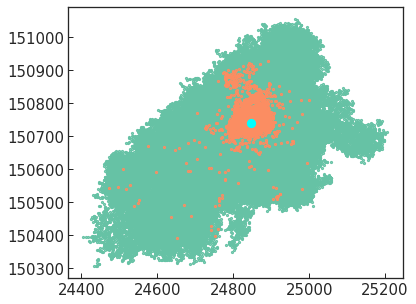